## Question 4 


Use the example data given above. Assume that the 
$y$
 values are generated by a straight line model where there is some intrinsic scatter to the line, and there are uncertainties in the 
$x$ and 
$y$
-direction, but there is no correlation between the 
$x$-and 
$y$-uncertainties.

You need to fully specify this model. That includes specifying the model parameters, the priors on those parameters, any marginalisations, the log likelihood function, and the log prior function.



In [6]:
#Loading the dataset and useful libraries and packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Ellipse
import scipy.optimize as op
from corner import corner
import emcee
from matplotlib.patches import Ellipse
# For reproducibility
np.random.seed(0)

# Load the data.
_, x, y, y_err, x_err, rho_xy = data = np.array([
    [1,  201, 592, 61,  9, -0.84],
    [2,  244, 401, 25,  4, +0.31],
    [3,   47, 583, 38, 11, +0.64],
    [4,  287, 402, 15,  7, -0.27],
    [5,  203, 495, 21,  5, -0.33],
    [6,   58, 173, 15,  9, +0.67],
    [7,  210, 479, 27,  4, -0.02],
    [8,  202, 504, 14,  4, -0.05],
    [9,  198, 510, 30, 11, -0.84],
    [10, 158, 416, 16,  7, -0.69],
    [11, 165, 393, 14,  5, +0.30],
    [12, 201, 442, 25,  5, -0.46],
    [13, 157, 317, 52,  5, -0.03],
    [14, 131, 311, 16,  6, +0.50],
    [15, 166, 400, 34,  6, +0.73],
    [16, 160, 337, 31,  5, -0.52],
    [17, 186, 423, 42,  9, +0.90],
    [18, 125, 334, 26,  8, +0.40],
    [19, 218, 533, 16,  6, -0.78],
    [20, 146, 344, 22,  5, -0.56],
]).T


## Question 5


Implement the model specified in Question 4 in a programming language of your choice.

Specify a sensible initial guess for the model parameters, and then optimise those parameters using an optimisation algorithm of your choice. Use an off-the-shelf Markov-chain Monte Carlo package to sample the model posteriors.

Plot the posterior distributions of the model parameters, and plot the posterior predictions of the model compared to the data.

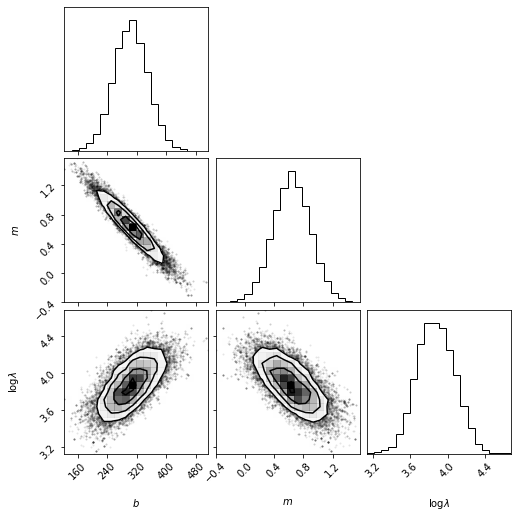

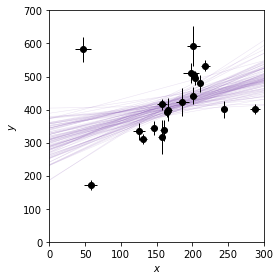

In [7]:
# Define model parameters and necessary matrices (based on linear algebra
# solution from lectures)

def ln_prior(theta):
    b, m, ln_lambda = theta
    return -3/2*np.log(1+m**2)


def ln_likelihood(theta, x, y, C):
    b, m, ln_lambda = theta
    
    #Define projection vector
    V = np.array([[-m, 1]]).T
    
    # Define orthogonal projection matrix.
    intrinsic_variance = (np.exp(ln_lambda)**2)
    Lambda = (intrinsic_variance / (1 + m**2)) * np.array([
        [m**2, -m],
        [-m,    1]
    ])
    
    Delta = (y - m*x -b)
    Sigma = (V.T @ (C + Lambda) @ V).flatten()
    
    
    return np.sum(-np.log(Sigma)-0.5*Delta**2/Sigma)

def ln_probability(theta, x, y, C):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return lp
    return lp + ln_likelihood(theta, x, y, C)

Y = np.atleast_2d(y).T
A = np.vstack([np.ones_like(x), x]).T
C = np.diag(y_err * y_err)
C_inv = np.linalg.inv(C)
G = np.linalg.inv(A.T @ C_inv @ A)
X = G @ (A.T @ C_inv @ Y)


#Define covariance matrix (note that off diagonal terms = 0 since the 
#x and y uncertainties are uncorrelated)
covs = np.array([[[x_e**2, x_e*y_e*rho*0],
                  [x_e*y_e*rho*0, y_e**2]] for y_e, x_e, rho in zip(y_err, x_err, rho_xy)])


#Optimise while taking lambda = -3 for initialisation
args = (x,y,covs)
initial_theta = np.hstack([X.T[0], -3])

result = op.minimize(lambda *args: -ln_probability(*args), initial_theta,
                     args=args,
                     method="L-BFGS-B",
                     bounds = [(None, None), (None, None), (-10, 10)])



#Sample model posteriors
ndim, nwalkers = (result.x.size, 32)
p0 = [result.x + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim,
    ln_probability,
    args=args
)

# Run the burn-in.
pos, *_ = sampler.run_mcmc(p0, 500)
sampler.reset()

# Run production.
sampler.run_mcmc(pos, 1000)

# Make a corner plot.
chain = sampler.chain.reshape((-1, ndim))

fig = corner(
    chain,
    labels=(r"$b$", r"$m$", r"$\log{\lambda}$")
)

#Make posterior predictions
fig, ax = plt.subplots(figsize=(4, 4))
    
ax.scatter(x, y, c="k", s=10)
ax.errorbar(x, y,
            xerr=x_err, yerr=y_err, 
            fmt="o", lw=1, c="k")

xlim = np.array([0, 300])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
    
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(7))
    
# Plot draws of the posterior.
for index in np.random.choice(chain.shape[0], size=100):
    b, m, ln_lambda = chain[index]
    ax.plot(
        xlim,
        m * xlim + b,
        "-",
        c="tab:purple",
        alpha=0.2,
        lw=0.5,
        zorder=-1
    )

ax.set_xlim(*xlim)
ax.set_ylim(0, 700)

fig.tight_layout()


## Question 6

Re-run your model from Question 5, but this time let us assume that the errors in the 
$x$ and
$y$ direction were incorrectly under-estimated!

The real errors are twice as large as the values given in the table above. Re-run your inferences with the real error values, and comment on changes to what you found in Question 5.

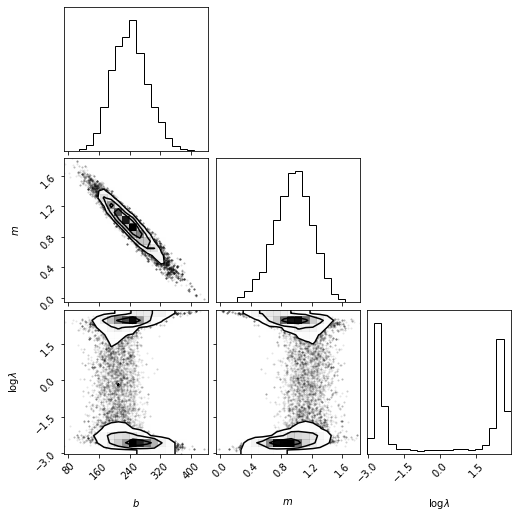

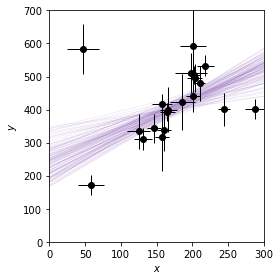

In [10]:
# Define model parameters and necessary matrices (based on linear algebra
# solution from lectures)

def ln_prior(theta):
    b, m, ln_lambda = theta
    return -3/2*np.log(1+m**2)


def ln_likelihood(theta, x, y, C):
    b, m, ln_lambda = theta
    
    #Define projection vector
    V = np.array([[-m, 1]]).T
    
    # Define orthogonal projection matrix.
    intrinsic_variance = (np.exp(ln_lambda**2))
    Lambda = (intrinsic_variance / (1 + m**2)) * np.array([
        [m**2, -m],
        [-m,    1]
    ])
    
    Delta = (y - m*x -b)
    Sigma = (V.T @ (C + Lambda) @ V).flatten()
    
    
    return np.sum(-np.log(Sigma)-0.5*Delta**2/Sigma)

def ln_probability(theta, x, y, C):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return lp
    return lp + ln_likelihood(theta, x, y, C)

Y = np.atleast_2d(y).T
A = np.vstack([np.ones_like(x), x]).T
C = np.diag(y_err * y_err)
C_inv = np.linalg.inv(C)
G = np.linalg.inv(A.T @ C_inv @ A)
X = G @ (A.T @ C_inv @ Y)


#Define covariance matrix (note that off diagonal terms = 0 since the 
#x and y uncertainties are uncorrelated)
covs = np.array([[[4*(x_e**2), x_e*y_e*rho*0],
                  [x_e*y_e*rho*0, 4*(y_e**2)]] for y_e, x_e, rho in zip(y_err, x_err, rho_xy)])


#Optimise while taking lambda = -3 for initialisation
args = (x,y,covs)
initial_theta = np.hstack([X.T[0], -3])

result = op.minimize(lambda *args: -ln_probability(*args), initial_theta,
                     args=args,
                     method="L-BFGS-B",
                     bounds = [(None, None), (None, None), (-10, 10)])



#Sample model posteriors
ndim, nwalkers = (result.x.size, 32)
p0 = [result.x + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim,
    ln_probability,
    args=args
)

# Run the burn-in.
pos, *_ = sampler.run_mcmc(p0, 1000)
sampler.reset()

# Run production.
sampler.run_mcmc(pos, 1000)

# Make a corner plot.
chain = sampler.chain.reshape((-1, ndim))

fig = corner(
    chain,
    labels=(r"$b$", r"$m$", r"$\log{\lambda}$")
)

#Make posterior predictions
fig, ax = plt.subplots(figsize=(4, 4))
    
ax.scatter(x, y, c="k", s=10)
ax.errorbar(x, y,
            xerr=2*x_err, yerr=2*y_err, 
            fmt="o", lw=1, c="k")

xlim = np.array([0, 300])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
    
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(7))
    
# Plot draws of the posterior.
for index in np.random.choice(chain.shape[0], size=100):
    b, m, ln_lambda = chain[index]
    ax.plot(
        xlim,
        m * xlim + b,
        "-",
        c="tab:purple",
        alpha=0.2,
        lw=0.5,
        zorder=-1
    )

ax.set_xlim(*xlim)
ax.set_ylim(0, 700)

fig.tight_layout()



<font color = "blue">The plots of the draws of the posterior in the above diagram appear to coincide with a larger number of data points despite the uncertainty in both the $x$ and $y$ directions beign doubled.The gradients of these linear graphs appear to approach a consistent value as compared to those in Question 5. While the plot for $m$ vs $b$ appears to be very similarly shaped to that of in Question 5, the same is not true for the plots of $b$ and $m$ vs $\log(\lambda)$, as these appear far more irregularly shaped compared to their elliptical counterparts in Question 5. The sclaes of the above graphs appear to also vary from their counterparts in Question 5 and in general, these appear to have smaller values, possibly indicating that the values for $\log(\lambda)$, $m$ and $b$ have decreased due to the uncertainties in both directions being doubled</font>

## Question 8

Implement the model from Question 7 in your programming language of choice.

Define the log likelihood function, the log prior function, and the log posterior probability function.

Calculate the log posterior probability on a grid in $\theta$ using sensible step sizes in each dimension, and plot the log posterior probability in all dimensions. Indicate the grid point with the highest log probability.



In [16]:
import numpy as np
import scipy.optimize as op

V = np.array([[-m, 1]]).T
    
# Define orthogonal projection matrix.
intrinsic_variance = (np.exp(ln_lambda)**2)
Lambda = (intrinsic_variance / (1 + m**2)) * np.array([
        [m**2, -m],
        [-m,    1]
    ])
    
Delta = (y - m*x -b)
Sigma = (V.T @ (C + Lambda) @ V).flatten()

np.random.seed(0)

_, x, y, y_err, x_err, rho_xy = np.array([
    [1,  201, 592, 61,  9, -0.84],
    [2,  244, 401, 25,  4, +0.31],
    [3,   47, 583, 38, 11, +0.64],
    [4,  287, 402, 15,  7, -0.27],
    [5,  203, 495, 21,  5, -0.33],
    [6,   58, 173, 15,  9, +0.67],
    [7,  210, 479, 27,  4, -0.02],
    [8,  202, 504, 14,  4, -0.05],
    [9,  198, 510, 30, 11, -0.84],
    [10, 158, 416, 16,  7, -0.69],
    [11, 165, 393, 14,  5, +0.30],
    [12, 201, 442, 25,  5, -0.46],
    [13, 157, 317, 52,  5, -0.03],
    [14, 131, 311, 16,  6, +0.50],
    [15, 166, 400, 34,  6, +0.73],
    [16, 160, 337, 31,  5, -0.52],
    [17, 186, 423, 42,  9, +0.90],
    [18, 125, 334, 26,  8, +0.40],
    [19, 218, 533, 16,  6, -0.78],
    [20, 146, 344, 22,  5, -0.56],
]).T



    
    
#Define covariance matrix with correlation between x and y uncertainties
C = np.array([[[x_e**2, x_e*y_e*rho],
                  [x_e*y_e*rho, y_e**2]] for 
              y_e, x_e, rho in zip(y_err, x_err, rho_xy)])


def ln_prior(theta):
    b, m, Q, mu_o, ln_sigma_v, ln_lambda = theta
    if not (1 > Q > 0) \
    or not (700 > mu_o > 0) \
    or not (5 > ln_sigma_v > -5) \
    or not (10 > ln_lambda > -10):
        return -np.inf

    return -3/2 * np.log(1 + m**2)

def ln_likelihood_fg(theta, x, y, C):
    b, m, Q, mu_o, ln_sigma_v,ln_lambda = theta
    
    return -0.5*((np.log(Sigma)-(Delta**2/Sigma)))


def ln_likelihood_bg(theta, x, y, y_err):
    b, m,  Q, mu_o, ln_sigma_v,ln_lambda = theta
    total_variance = y_err**2 + (np.exp(ln_sigma_v))**2
    return -0.5 * ((y - mu_o)**2 / total_variance) - 0.5 * np.log(total_variance)
    
def ln_probability_q8(theta, x, y, y_err, C):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return (-np.inf, np.nan * np.ones((2, x.size)))
    
    b, m, Q, mu_o, ln_sigma_v, ln_lambda = theta
    # Compute weighted foreground likelihoods for each data point.
    # (They are weighted by the log(Q) term)
    ll_fg = np.log(Q) + ln_likelihood_fg(theta, x, y, C)
    
    # Compute weighted background likelihoods for each data point.
    ll_bg = np.log(1 - Q) + ln_likelihood_bg(theta, x, y, y_err)

    # Sum the log of the sum of the exponents of the log likelihoods.
    ll = np.sum(np.logaddexp(ll_fg, ll_bg))
    return (lp + ll, np.vstack([ll_fg, ll_bg]))


args = (x, y, y_err, C)
initial_theta = np.array([250, 1, 0.5, 400, -3])
# Use optimize.brute to determine the -ve log likelihood is minimised
result = op.brute(
    lambda *args: -ln_probability_q8(*args)[0],
    args=args,
    ranges=[
        (0, 1000),
        (0, 1000),
        (0, 1),
        (0, 700),
        (-5, 5),
        (-10, 10)
    ], Ns = 10
)

#Unsure of how to plot and log_likelihood background function appears to produce
# a value error when I input the Sigma and Delta matrices from the intrinsic scatter
# model

for i in range(len(*args[0])):
    plt.contour(-ln_probability_q8(*args, C)[0][i], -ln_probability_q8)


ValueError: operands could not be broadcast together with shapes (20,20) (2,2) 